# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [92]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Core Data Science
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Data Processing
import rioxarray as rxr
import rasterio

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Machine Learning - Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model Persistence
import joblib

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [93]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("../data/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

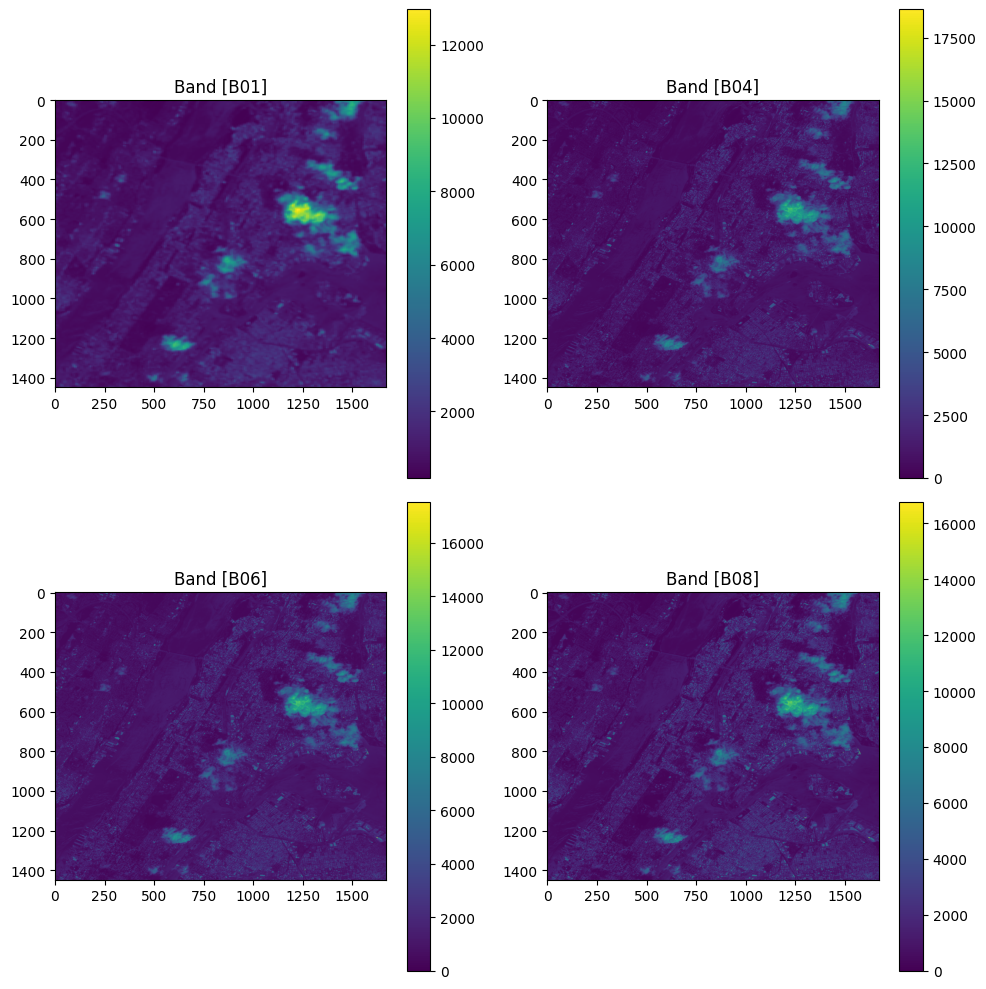

In [94]:
# Open the GeoTIFF file
tiff_path = "../data/S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [95]:
def map_satellite_data_with_buffer(tiff_path, csv_path, buffer_radius=700, 
                                  weighting='gaussian', land_cover_mask=None, 
                                  outlier_threshold=3, min_valid_pixels=5,
                                  adaptive_weighting=False, drop_invalid=True,
                                  handle_out_of_bounds='nearest'):
    """
    Extracts satellite band values from a GeoTIFF based on coordinates from a csv file,
    using advanced buffer techniques with customizable weighting schemes.
    
    Parameters:
    tiff_path (str): Path to the GeoTIFF file
    csv_path (str): Path to the CSV file containing coordinates
    buffer_radius (float): Radius in meters for the buffer zone (default: 700)
    weighting (str): Weighting method to use - options:
                    'uniform' - equal weight to all pixels (simple average)
                    'gaussian' - gaussian distance weighting (default)
                    'inverse' - inverse distance weighting
                    'triangular' - linear decrease with distance
    land_cover_mask (str): Optional path to land cover raster for masking (e.g., to exclude water pixels)
    outlier_threshold (float): Standard deviation threshold for outlier removal (default: 3)
    min_valid_pixels (int): Minimum number of valid pixels required (default: 5)
    adaptive_weighting (bool): If True, selects best weighting method for each point based on local variance (default: False)
    drop_invalid (bool): If True, drops points that are outside raster bounds or have NaN values (default: True)
    handle_out_of_bounds (str): How to handle points outside raster bounds:
                               'drop' - drop these points
                               'nearest' - use nearest valid pixel values
                               'knn' - use k-nearest neighbor interpolation from valid points
    
    Returns:
    pd.DataFrame: DataFrame containing processed band values for each input location with metadata
    """
    # Load the GeoTIFF data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = rxr.open_rasterio(tiff_path)
    
    # Load land cover mask if provided
    if land_cover_mask is not None:
        try:
            lc_data = rxr.open_rasterio(land_cover_mask)
        except Exception as e:
            print(f"Warning: Could not load land cover mask: {e}")
            land_cover_mask = None
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    # Make sure latitude and longitude columns exist
    required_cols = ['Latitude', 'Longitude']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV must contain {', '.join(required_cols)} columns")
    
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Calculate buffer size in pixels (assuming 10m resolution)
    buffer_pixels = int(np.ceil(buffer_radius / 10))
    
    # Identify band names from the raster data
    if hasattr(data, 'band_names') and data.band_names:
        band_names = data.band_names
    else:
        # Default Sentinel-2 band names
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 
                      'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
        if data.shape[0] != len(band_names):
            band_names = [f'Band_{i+1}' for i in range(data.shape[0])]
    
    # Initialize dictionary for band values and metadata
    result_dict = {band_name: [] for band_name in band_names}
    metadata = {
        'Latitude': [], 'Longitude': [], 
        'buffer_radius_m': [], 'pixels_used': [],
        'weighting': [], 'stddev': [], 'outliers_removed': []
    }

    # Get the affine transform from the data
    transform = data.rio.transform()
    resolution = data.rio.resolution()[0]  # Assuming square pixels
    
    # Define weighting function
    def get_weights(distances, method, radius):
        # Handle empty array
        if len(distances) == 0:
            return np.array([])
            
        if method == 'uniform':
            return np.ones_like(distances)
        elif method == 'gaussian':
            # Gaussian with sigma = radius/3 (so most weight is within radius)
            sigma = radius / 3
            return np.exp(-(distances**2) / (2 * sigma**2))
        elif method == 'inverse':
            # Add small epsilon to avoid division by zero
            return 1 / (distances + 0.1)
        elif method == 'triangular':
            # Linear decrease with distance
            return np.maximum(0, 1 - distances/radius)
        else:
            # Default to uniform if unknown method
            warnings.warn(f"Unknown weighting method: {method}, using uniform instead")
            return np.ones_like(distances)
    
    # Prepare for adaptive weighting
    weighting_methods = ['uniform', 'gaussian', 'inverse', 'triangular'] if adaptive_weighting else [weighting]
    
    # Collect all valid and invalid points for potential interpolation
    valid_points = []
    invalid_indices = []
    
    # Iterate over the latitudes and longitudes
    invalid_points = 0
    for idx, (lat, lon) in enumerate(tqdm(zip(latitudes, longitudes), 
                                         total=len(latitudes), 
                                         desc="Processing locations")):
        # Convert lat/lon to pixel coordinates
        col, row = ~transform * (lon, lat)
        row, col = int(row), int(col)
        
        # Check if point is within raster bounds
        if (row < 0 or row >= data.rio.width or 
            col < 0 or col >= data.rio.height):
            invalid_points += 1
            invalid_indices.append(idx)
            
            # For invalid points, we'll handle them based on the chosen method
            if handle_out_of_bounds == 'drop':
                # Fill with NaN (original behavior)
                for band_name in band_names:
                    result_dict[band_name].append(np.nan)
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(np.nan)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(np.nan)
                continue
            else:
                # For 'nearest' and 'knn' methods, add placeholders temporarily
                for band_name in band_names:
                    result_dict[band_name].append(None)  # Placeholder to maintain index
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(0)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(0)
                continue
        
        # Keep track of valid points for potential interpolation
        valid_points.append((idx, lat, lon, row, col))
        
        # Calculate window bounds with padding to handle edge cases
        row_start = max(0, row - buffer_pixels)
        row_end = min(data.rio.width, row + buffer_pixels + 1)
        col_start = max(0, col - buffer_pixels)
        col_end = min(data.rio.height, col + buffer_pixels + 1)
        
        # Create a grid of pixel coordinates for the window
        y_indices, x_indices = np.indices((col_end - col_start, row_end - row_start))
        y_coords = y_indices + col_start
        x_coords = x_indices + row_start
        
        # Calculate distances from center point (in meters)
        distances = np.sqrt((x_coords - row)**2 + (y_coords - col)**2) * resolution
        
        # Create mask for pixels within buffer radius
        distance_mask = distances <= buffer_radius
        
        # Apply land cover mask if provided
        if land_cover_mask is not None:
            try:
                lc_window = lc_data[0, col_start:col_end, row_start:row_end].values
                # Assuming water classes are 0 or 1 (modify as needed for your land cover data)
                water_mask = ~np.isin(lc_window, [0, 1])
                combined_mask = distance_mask & water_mask
            except Exception:
                combined_mask = distance_mask
        else:
            combined_mask = distance_mask
        
        # Implement adaptive weighting if requested
        if adaptive_weighting:            
            # Get a sample band to analyze local characteristics
            sample_band_idx = min(3, len(band_names) - 1)  # Use band ~4 if available (good middle ground)
            sample_window = data[sample_band_idx, col_start:col_end, row_start:row_end].values
            valid_pixels = sample_window[distance_mask & ~np.isnan(sample_window)]
            
            # Skip adaptive weighting if not enough valid pixels
            if len(valid_pixels) < min_valid_pixels * 2:
                # Fall back to specified weighting method
                weighting_methods = [weighting]
            else:
                # Calculate metrics to determine best weighting method
                window_mean = np.mean(valid_pixels)
                window_cv = np.std(valid_pixels) / (window_mean + 1e-10)  # Coefficient of variation
                
                edge_values = sample_window[((x_coords == row_start) | (x_coords == row_end - 1) | 
                                           (y_coords == col_start) | (y_coords == col_end - 1)) & 
                                          distance_mask & ~np.isnan(sample_window)]
                center_values = sample_window[((x_coords - row)**2 + (y_coords - col)**2 <= (buffer_pixels/3)**2) & 
                                            ~np.isnan(sample_window)]
                
                # Calculate center-to-edge gradient 
                edge_mean = np.mean(edge_values) if len(edge_values) > 0 else window_mean
                center_mean = np.mean(center_values) if len(center_values) > 0 else window_mean
                gradient = abs(center_mean - edge_mean) / (window_mean + 1e-10)
                
                # Select weighting method based on local characteristics
                if gradient > 0.3:  # Strong center-to-edge gradient
                    # Strong gradient suggests gaussian or inverse weighting
                    weighting_methods = ['gaussian', 'inverse']
                elif window_cv < 0.1:  # Low variation
                    # Low variation suggests uniform weighting
                    weighting_methods = ['uniform']
                elif window_cv > 0.3:  # High variation
                    # High variation suggests triangular or gaussian (balance)
                    weighting_methods = ['triangular', 'gaussian']
                # Otherwise test all methods
        
        # Process each band
        point_metadata = {
            'pixels_used': 0,
            'stddev': [],
            'outliers_removed': 0,
            'selected_weighting': weighting
        }
        
        # Store results for each weighting method if adaptive weighting is used
        if len(weighting_methods) > 1:
            weighting_results = {method: {} for method in weighting_methods}
        
        for band_idx, band_name in enumerate(band_names):
            # Get the band data for the window
            try:
                window_data = data[band_idx, col_start:col_end, row_start:row_end].values
            except IndexError:
                # Handle case where band index doesn't match data dimensions
                result_dict[band_name].append(np.nan)
                continue
                
            # Apply mask and get valid values
            valid_mask = combined_mask & ~np.isnan(window_data)
            valid_values = window_data[valid_mask]
            valid_weights = get_weights(distances[valid_mask], weighting_methods[0], buffer_radius)
            
            # Skip if no valid values
            if len(valid_values) < min_valid_pixels:
                if len(weighting_methods) > 1:
                    for method in weighting_methods:
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = np.nan
                else:
                    result_dict[band_name].append(np.nan)
                continue
                
            # Store initial number of pixels
            initial_pixels = len(valid_values)
            
            # Remove outliers if requested and if we have enough data points
            if outlier_threshold is not None and len(valid_values) > 10:
                mean = np.mean(valid_values)
                std = np.std(valid_values)
                if std > 0:  # Only filter if there's actually variation
                    outlier_mask = np.abs(valid_values - mean) <= (outlier_threshold * std)
                    
                    # Update values and weights
                    valid_values = valid_values[outlier_mask]
                    valid_weights = valid_weights[outlier_mask]
                    outliers_removed = initial_pixels - len(valid_values)
                    point_metadata['outliers_removed'] = outliers_removed
            
            # Calculate weighted average
            if len(valid_values) > 0:
                # If testing multiple weighting methods
                if len(weighting_methods) > 1:
                    # Store results for each method
                    for method in weighting_methods:
                        method_weights = get_weights(distances[valid_mask], method, buffer_radius)
                        # Ensure weights and values have the same shape
                        if len(method_weights) != len(valid_values):
                            # Reshape weights to match values
                            if len(valid_values) < len(method_weights):
                                method_weights = method_weights[:len(valid_values)]
                            else:
                                # Pad weights if necessary (shouldn't happen in normal cases)
                                pad_length = len(valid_values) - len(method_weights)
                                method_weights = np.pad(method_weights, (0, pad_length), 'constant', constant_values=(0,))
                        
                        # Normalize weights (ensure they sum to 1)
                        if np.sum(method_weights) > 0:
                            method_weights = method_weights / np.sum(method_weights)
                        else:
                            method_weights = np.ones_like(valid_values) / len(valid_values)
                            
                        # Calculate weighted average
                        weighted_avg = np.sum(valid_values * method_weights)
                        std_dev = np.std(valid_values)
                        
                        # Store in temporary dictionary
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = weighted_avg
                            weighting_results[method]['stddev'] = [std_dev]
                        else:
                            weighting_results[method]['stddev'].append(std_dev)
                else:
                    # Single weighting method (standard case)
                    # Normalize weights
                    valid_weights = valid_weights / np.sum(valid_weights)
                    weighted_avg = np.sum(valid_values * valid_weights)
                    std_dev = np.std(valid_values)
                    
                    result_dict[band_name].append(weighted_avg)
                    point_metadata['pixels_used'] = len(valid_values)
                    point_metadata['stddev'].append(std_dev)
            else:
                # Fallback to center pixel if no valid values in buffer
                try:
                    center_value = data[band_idx, col, row].values
                    center_value_float = float(center_value)
                    
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = center_value_float
                    else:
                        result_dict[band_name].append(center_value_float)
                except:
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = np.nan
                    else:
                        result_dict[band_name].append(np.nan)
        
        # If using adaptive weighting, select the best method
        if len(weighting_methods) > 1:
            # Criteria for selecting best weighting method:
            # 1. Lowest coefficient of variation of spectral indices (if we have enough bands)
            # 2. Balance between spatial smoothness and feature preservation
            
            method_scores = {}
            for method in weighting_methods:
                # Calculate mean and variance across bands
                band_values = [val for key, val in weighting_results[method].items() 
                              if key not in ['stddev'] and not np.isnan(val)]
                
                if len(band_values) >= 3:  # Need at least a few bands for a meaningful analysis
                    # Calculate coefficient of variation (lower is better for stability)
                    cv = np.std(band_values) / (np.mean(np.abs(band_values)) + 1e-10)
                    
                    # Calculate average standard deviation (lower is better for noise reduction)
                    avg_stddev = np.mean(weighting_results[method].get('stddev', [0]))
                    
                    # Score based on balance between CV and stddev
                    # We prefer methods that balance smoothness (low stddev) with feature preservation (not too low CV)
                    score = -cv * 0.4 - (avg_stddev / (np.mean(np.abs(band_values)) + 1e-10)) * 0.6
                    method_scores[method] = score
            
            # Select best method (highest score)
            if method_scores:
                best_method = max(method_scores.items(), key=lambda x: x[1])[0]
                point_metadata['selected_weighting'] = best_method
                
                # Add the values from best method to result
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
                
                # Update metadata
                if 'stddev' in weighting_results[best_method]:
                    point_metadata['stddev'] = np.mean(weighting_results[best_method]['stddev'])
                else:
                    point_metadata['stddev'] = np.nan
            else:
                # If no valid scores, use default weighting
                best_method = weighting
                point_metadata['selected_weighting'] = best_method
                
                # Add results using default method
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
        
        # Calculate average standard deviation across bands
        if point_metadata['stddev'] and not isinstance(point_metadata['stddev'], float):
            point_metadata['stddev'] = np.mean(point_metadata['stddev'])
            
        # Add metadata
        metadata['Latitude'].append(lat)
        metadata['Longitude'].append(lon)
        metadata['buffer_radius_m'].append(buffer_radius)
        metadata['pixels_used'].append(point_metadata['pixels_used'])
        metadata['weighting'].append(point_metadata['selected_weighting'])
        metadata['stddev'].append(point_metadata['stddev'])
        metadata['outliers_removed'].append(point_metadata['outliers_removed'])
    
    # Handle out-of-bounds points after processing valid ones
    if handle_out_of_bounds in ['nearest', 'knn'] and invalid_points > 0 and valid_points:
        print(f"Interpolating values for {invalid_points} out-of-bounds points...")
        
        # Need to import required libraries here for interpolation
        if handle_out_of_bounds == 'nearest':
            from scipy.spatial import cKDTree
        elif handle_out_of_bounds == 'knn':
            from sklearn.neighbors import KNeighborsRegressor
        
        # Extract valid lat/lon for interpolation
        valid_indices = [p[0] for p in valid_points]
        valid_lats = [p[1] for p in valid_points]
        valid_lons = [p[2] for p in valid_points]
        
        # For each band, interpolate values for invalid points
        for band_name in band_names:
            # Skip if this band wasn't processed for valid points
            if not all(isinstance(result_dict[band_name][i], (int, float)) for i in valid_indices):
                continue
                
            valid_values = [result_dict[band_name][i] for i in valid_indices 
                           if isinstance(result_dict[band_name][i], (int, float))]
            valid_coords = np.column_stack(([valid_lats[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))],
                                          [valid_lons[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))]))
            
            if len(valid_values) == 0 or len(valid_coords) == 0:
                continue
                
            if handle_out_of_bounds == 'nearest':
                # For each invalid point, find the nearest valid point
                # Build KD-tree with valid points
                tree = cKDTree(valid_coords)
                
                # For each invalid point
                for idx in invalid_indices:
                    invalid_lat = latitudes[idx]
                    invalid_lon = longitudes[idx]
                    
                    # Find nearest neighbor
                    dist, nn_idx = tree.query([invalid_lat, invalid_lon], k=1)
                    
                    # Use the value from nearest neighbor
                    result_dict[band_name][idx] = valid_values[nn_idx]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"nearest_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = 1
            
            elif handle_out_of_bounds == 'knn':
                # K-nearest neighbors interpolation
                # Create and fit KNN model
                k = min(5, len(valid_coords))  # Use at most 5 neighbors
                knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
                knn.fit(valid_coords, valid_values)
                
                # Interpolate for invalid points
                invalid_coords = np.column_stack(([latitudes[i] for i in invalid_indices],
                                                 [longitudes[i] for i in invalid_indices]))
                
                interpolated_values = knn.predict(invalid_coords)
                
                # Assign interpolated values
                for i, idx in enumerate(invalid_indices):
                    result_dict[band_name][idx] = interpolated_values[i]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"knn{k}_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = k

    if invalid_points > 0:
        if handle_out_of_bounds == 'drop':
            print(f"Warning: {invalid_points} points were outside the raster bounds.")
        else:
            print(f"Handled {invalid_points} out-of-bounds points using '{handle_out_of_bounds}' method.")
    
    # Create results DataFrame
    result_df = pd.DataFrame(result_dict)
    
    # Add metadata columns
    for key, values in metadata.items():
        result_df[key] = values
    
    # Add derived spectral indices relevant for urban heat island studies
    try:
        # Reference band names for Sentinel-2
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
        available_bands = [band for band in band_names if band in result_df.columns]
        
        # Add a tiny constant to prevent division by zero
        epsilon = 1e-10
        
        # BASIC BAND RATIOS - Simple but powerful features
        # Iterate through all possible band combinations to create ratios
        for i, band1 in enumerate(available_bands):
            for j, band2 in enumerate(available_bands):
                if i < j:  # Avoid duplicates and self-ratios
                    ratio_name = f"{band1}_{band2}_ratio"
                    result_df[ratio_name] = result_df[band1] / (result_df[band2] + epsilon)
        
        # VEGETATION INDICES
        # NDVI - Normalized Difference Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            result_df['NDVI'] = (result_df['B08'] - result_df['B04']) / (result_df['B08'] + result_df['B04'] + epsilon)
        
        # EVI - Enhanced Vegetation Index (reduces atmospheric and soil background influences)
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08']):
            result_df['EVI'] = 2.5 * ((result_df['B08'] - result_df['B04']) / 
                                    (result_df['B08'] + 6 * result_df['B04'] - 7.5 * result_df['B02'] + 1 + epsilon))
        
        # SAVI - Soil Adjusted Vegetation Index (L=0.5 typically)
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            L = 0.5  # Soil brightness correction factor
            result_df['SAVI'] = ((result_df['B08'] - result_df['B04']) / 
                            (result_df['B08'] + result_df['B04'] + L + epsilon)) * (1 + L)
        
        # MSAVI2 - Modified Soil Adjusted Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            NIR = result_df['B08']
            RED = result_df['B04']
            result_df['MSAVI'] = (2 * NIR + 1 - np.sqrt((2 * NIR + 1)**2 - 8 * (NIR - RED))) / 2
        
        # ARVI - Atmospherically Resistant Vegetation Index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08']):
            # Using blue band (B02) to correct for atmospheric scattering
            RB = result_df['B04'] - (result_df['B02'] - result_df['B04'])  # Red - (Blue - Red)
            result_df['ARVI'] = (result_df['B08'] - RB) / (result_df['B08'] + RB + epsilon)
        
        # GNDVI - Green Normalized Difference Vegetation Index
        if 'B08' in result_df.columns and 'B03' in result_df.columns:
            result_df['GNDVI'] = (result_df['B08'] - result_df['B03']) / (result_df['B08'] + result_df['B03'] + epsilon)
        
        # RVI - Ratio Vegetation Index (simple but effective)
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            result_df['RVI'] = result_df['B08'] / (result_df['B04'] + epsilon)
        
        # WATER INDICES
        # NDWI - Normalized Difference Water Index (Green-NIR)
        if 'B03' in result_df.columns and 'B08' in result_df.columns:
            result_df['NDWI'] = (result_df['B03'] - result_df['B08']) / (result_df['B03'] + result_df['B08'] + epsilon)
        
        # MNDWI - Modified NDWI (Green-SWIR)
        if 'B03' in result_df.columns and 'B11' in result_df.columns:
            result_df['MNDWI'] = (result_df['B03'] - result_df['B11']) / (result_df['B03'] + result_df['B11'] + epsilon)
        
        # WRI - Water Ratio Index
        if all(band in result_df.columns for band in ['B03', 'B04', 'B08', 'B11']):
            result_df['WRI'] = (result_df['B03'] + result_df['B04']) / (result_df['B08'] + result_df['B11'] + epsilon)
        
        # AWEI - Automated Water Extraction Index
        if all(band in result_df.columns for band in ['B02', 'B03', 'B08', 'B11', 'B12']):
            result_df['AWEI'] = 4 * (result_df['B03'] - result_df['B11']) - (0.25 * result_df['B08'] + 2.75 * result_df['B12'])
        
        # BUILT-UP/URBAN INDICES
        # NDBI - Normalized Difference Built-up Index
        if 'B08' in result_df.columns and 'B11' in result_df.columns:
            result_df['NDBI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + epsilon)
        
        # BUI - Built-Up Index (combination of NDBI and NDVI)
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['BUI'] = result_df['NDBI'] - result_df['NDVI']
        
        # UI - Urban Index
        if 'B07' in result_df.columns and 'B04' in result_df.columns:
            result_df['UI'] = (result_df['B07'] - result_df['B04']) / (result_df['B07'] + result_df['B04'] + epsilon)
        
        # NDBaI - Normalized Difference Bareness Index
        if 'B11' in result_df.columns and 'B12' in result_df.columns:
            result_df['NDBaI'] = (result_df['B11'] - result_df['B12']) / (result_df['B11'] + result_df['B12'] + epsilon)
        
        # THERMAL/HEAT RELATED INDICES
        # NBDI - Normalized Difference Bareness Index (different from NDBaI)
        if 'B11' in result_df.columns and 'B08' in result_df.columns:
            result_df['NBDI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + epsilon)
        
        # BSI - Bare Soil Index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08', 'B11']):
            result_df['BSI'] = ((result_df['B04'] + result_df['B11']) - (result_df['B08'] + result_df['B02'])) / \
                            ((result_df['B04'] + result_df['B11']) + (result_df['B08'] + result_df['B02']) + epsilon)
        
        # IBI - Index-based Built-up Index
        if all(ind in result_df.columns for ind in ['NDBI', 'SAVI', 'MNDWI']):
            IBI_num = result_df['NDBI'] - (result_df['SAVI'] + result_df['MNDWI']) / 2
            IBI_denom = result_df['NDBI'] + (result_df['SAVI'] + result_df['MNDWI']) / 2
            result_df['IBI'] = IBI_num / (IBI_denom + epsilon)
        
        # EBBI - Enhanced Built-Up and Bareness Index
        if all(band in result_df.columns for band in ['B08', 'B11', 'B12']):
            result_df['EBBI'] = (result_df['B11'] - result_df['B08']) / \
                            (10 * np.sqrt(result_df['B11'] + result_df['B12'] + epsilon))
        
        # UTFVI - Urban Thermal Field Variance Index (using SWIR bands as proxy for temperature)
        if 'B11' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['UTFVI'] = (result_df['B11'] - result_df['NDVI']) / (result_df['B11'] + result_df['NDVI'] + epsilon)
        
        # NEW AND EXPERIMENTAL INDICES FOR URBAN HEAT ISLANDS
        
        # NDISI - Normalized Difference Impervious Surface Index
        # Useful for impervious surface mapping in urban areas
        if all(band in result_df.columns for band in ['B03', 'B8A', 'B11', 'B12']):
            MIR_SW = (result_df['B11'] + result_df['B12']) / 2  # Mid-infrared and shortwave combined
            result_df['NDISI'] = (result_df['B11'] - (result_df['B03'] + result_df['B8A'] + MIR_SW) / 3) / \
                            (result_df['B11'] + (result_df['B03'] + result_df['B8A'] + MIR_SW) / 3 + epsilon)
        
        # UHI - Urban Heat Island Index (experimental)
        # Combines thermal (SWIR) with vegetation and built-up indices
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']):
            if 'B11' in result_df.columns:  # Using B11 (SWIR) as thermal proxy
                result_df['UHI'] = result_df['B11'] * (1 - result_df['NDVI']) * result_df['NDBI']
        
        # COMPOSITE INDICES USING MULTIPLICATION
        # Vegetation-Water Interaction Index
        if 'NDVI' in result_df.columns and 'NDWI' in result_df.columns:
            result_df['VWI'] = result_df['NDVI'] * result_df['NDWI']
        
        # Urban-Vegetation Contrast Index
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['UVCI'] = result_df['NDBI'] * (1 - result_df['NDVI'])
        
        # Thermal-Vegetation-Built-up Index
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']) and 'B11' in result_df.columns:
            # Normalize B11 to 0-1 range for better scaling
            B11_norm = (result_df['B11'] - result_df['B11'].min()) / (result_df['B11'].max() - result_df['B11'].min() + epsilon)
            result_df['TVBI'] = B11_norm * result_df['NDBI'] * (1 - result_df['NDVI'])
        
        # MULTI-BAND COMBINATIONS
        # Create tri-band combinations (useful for capturing complex surface properties)
        for i, band1 in enumerate(available_bands[:6]):  # Limit to avoid too many features
            for j, band2 in enumerate(available_bands[:6]):
                for k, band3 in enumerate(available_bands[:6]):
                    if i < j < k:  # Avoid duplicates
                        combo_name = f"{band1}_{band2}_{band3}_combo"
                        result_df[combo_name] = result_df[band1] * result_df[band2] * result_df[band3]
        
        # TEXTURE AND CONTEXTUAL FEATURES
        # Relative band positions can indicate surface properties
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11']):
            # RED-NIR-SWIR relationship captures vegetation-soil-moisture interactions
            result_df['R_NIR_SWIR_pattern'] = (result_df['B04'] < result_df['B08']).astype(int) * 4 + \
                                        (result_df['B08'] > result_df['B11']).astype(int) * 2 + \
                                        (result_df['B04'] < result_df['B11']).astype(int)
        
        # PRINCIPAL COMPONENT PROXIES
        # Simple linear combinations that mimic principal components for urban areas
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08', 'B11']):
            result_df['urban_PC1_proxy'] = 0.3*result_df['B02'] + 0.2*result_df['B03'] + \
                                        0.2*result_df['B04'] + 0.1*result_df['B08'] + 0.2*result_df['B11']
            
            result_df['urban_PC2_proxy'] = -0.2*result_df['B02'] - 0.2*result_df['B03'] + \
                                        0.1*result_df['B04'] + 0.5*result_df['B08'] - 0.2*result_df['B11']
        
        # GROUP RATIOS
        # VIS/NIR Ratio (average visible bands to NIR)
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08']):
            result_df['VIS_NIR_ratio'] = (result_df['B02'] + result_df['B03'] + result_df['B04']) / \
                                    (3 * result_df['B08'] + epsilon)
        
        # NIR/SWIR Ratio (sensitive to moisture and built-up surfaces)
        if 'B08' in result_df.columns and 'B11' in result_df.columns and 'B12' in result_df.columns:
            result_df['NIR_SWIR_ratio'] = result_df['B08'] / \
                                    ((result_df['B11'] + result_df['B12']) / 2 + epsilon)
        
        # ADVANCED UHI-SPECIFIC INDICES
        
        # Urban Cooling Efficiency Index - Ratio of cooling capacity to heat production
        if 'NDVI' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['UCEI'] = result_df['NDVI'] / (result_df['NDBI'] + 1 + epsilon)  # +1 to make denominator positive
        
        # Surface Albedo Proxy - Reflectance combination across visible and NIR
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08']):
            result_df['albedo_proxy'] = 0.3 * result_df['B02'] + 0.3 * result_df['B03'] + \
                                    0.2 * result_df['B04'] + 0.2 * result_df['B08']
        
        # Heat Absorption Potential Index
        if 'albedo_proxy' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['HAPI'] = (1 - result_df['albedo_proxy']) * result_df['NDBI']
        
        # Normalized Thermal-Vegetation-Built Index - For UHI core identification
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']) and 'B11' in result_df.columns:
            # Using B11 (SWIR1) as thermal proxy
            thermal_proxy = (result_df['B11'] - result_df['B11'].min()) / (result_df['B11'].max() - result_df['B11'].min() + epsilon)
            result_df['NTVBI'] = (thermal_proxy + result_df['NDBI'] - result_df['NDVI']) / \
                            (thermal_proxy + result_df['NDBI'] + result_df['NDVI'] + epsilon)
        
        # BAND TRANSFORMATIONS
        # Tasseled Cap Transformation proxies for Sentinel-2
        # (Coefficients approximated from literature)
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']):
            # Brightness - sensitive to total reflectance
            result_df['TCB'] = 0.3037*result_df['B02'] + 0.2793*result_df['B03'] + 0.4743*result_df['B04'] + \
                            0.5585*result_df['B08'] + 0.5082*result_df['B11'] + 0.1863*result_df['B12']
            
            # Greenness - sensitive to vegetation
            result_df['TCG'] = -0.2848*result_df['B02'] - 0.2435*result_df['B03'] - 0.5436*result_df['B04'] + \
                            0.7243*result_df['B08'] + 0.0840*result_df['B11'] - 0.1800*result_df['B12']
            
            # Wetness - sensitive to soil and canopy moisture
            result_df['TCW'] = 0.1509*result_df['B02'] + 0.1973*result_df['B03'] + 0.3279*result_df['B04'] + \
                            0.3406*result_df['B08'] - 0.7112*result_df['B11'] - 0.4572*result_df['B12']
            
            
    except Exception as e:
        print(f"Warning: Could not calculate some indices: {e}")
        
    if drop_invalid:
        initial_rows = len(result_df)
        
        # Create a mask for rows where any band column contains NaN or null values
        band_columns = [col for col in result_df.columns if col in band_names]
        
        # Check for NaN, None, and other invalid values
        # This combines checks for np.nan, None, and other invalid values
        invalid_mask = result_df[band_columns].isna().any(axis=1)  # Catches np.nan
        
        # Also consider rows with very extreme values that might indicate errors
        # (optional - remove if not needed for your specific data)
        for col in band_columns:
            if col in result_df.columns:
                # Check for infinite values
                if result_df[col].dtype.kind in 'fc':  # float or complex columns
                    invalid_mask = invalid_mask | np.isinf(result_df[col])
        
        # Drop the rows that have invalid values
        result_df = result_df[~invalid_mask]
        
        # Report the number of dropped rows
        dropped_rows = initial_rows - len(result_df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing/invalid values.")
    
    return result_df

In [96]:
final_data = map_satellite_data_with_buffer(
    '../data/S2_sample.tiff',
    '../data/Training_data_uhi_index_2025-02-18.csv',
    buffer_radius=650,
    adaptive_weighting=True,
    outlier_threshold=2.5,
    drop_invalid=False,
    handle_out_of_bounds='knn'
)

Processing locations: 100%|██████████| 11229/11229 [02:46<00:00, 67.26it/s]


Interpolating values for 36 out-of-bounds points...
Handled 36 out-of-bounds points using 'knn' method.


In [97]:
final_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,urban_PC2_proxy,VIS_NIR_ratio,NIR_SWIR_ratio,UCEI,albedo_proxy,HAPI,NTVBI,TCB,TCG,TCW
0,1028.458534,992.566540,1117.398068,1113.262303,1248.279147,1401.679610,1481.907630,1420.872793,1519.694504,1403.095408,...,119.150624,0.756161,1.095071,0.122156,1139.816401,7.169053,0.283129,2870.220390,-227.489189,-323.605984
1,1028.458534,992.566540,1117.398068,1113.262303,1248.279147,1401.679610,1481.907630,1420.872793,1519.694504,1403.095408,...,119.150624,0.756161,1.095071,0.122156,1139.816401,7.169053,0.283129,2870.220390,-227.489189,-323.605984
2,1026.144220,991.466989,1116.757305,1112.303489,1246.044249,1398.014432,1475.994244,1415.398169,1515.291347,1397.123253,...,117.859924,0.758450,1.096383,0.120693,1138.007620,7.387933,0.286040,2861.833776,-229.684260,-318.575046
3,1024.788708,990.489363,1115.251298,1109.635205,1241.130061,1391.701539,1467.068666,1408.353809,1508.716312,1386.906483,...,116.610996,0.761025,1.099012,0.119551,1135.320001,8.703351,0.284484,2849.088799,-231.968944,-311.014235
4,1023.433196,989.555824,1114.370013,1107.975730,1237.223413,1385.935825,1460.755199,1401.192932,1502.191464,1378.974760,...,114.813920,0.764087,1.100771,0.117800,1133.011484,9.046658,0.287616,2838.032806,-234.788074,-304.477025


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [98]:
def combine_two_datasets(dataset1, dataset2):
    """
    Combine two datasets horizontally (column-wise) without duplicating common columns
    like 'Longitude' and 'Latitude'.
    
    Parameters:
    -----------
    dataset1 : DataFrame
        First DataFrame to combine
    dataset2 : DataFrame
        Second DataFrame to combine
        
    Returns:
    --------
    DataFrame
        Combined DataFrame without duplicated coordinate columns
    """
    # Identify common columns (typically coordinates)
    common_cols = ['Longitude', 'Latitude']
    existing_common_cols = [col for col in common_cols if col in dataset1.columns and col in dataset2.columns]
    
    if existing_common_cols:
        # Use merge on common columns to avoid duplication
        return pd.merge(dataset1, dataset2, on=existing_common_cols, how='inner')
    else:
        # If no common columns, fall back to concat but with a warning
        print("Warning: No common coordinate columns found. Using direct concatenation.")
        return pd.concat([dataset1, dataset2], axis=1)

In [99]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,urban_PC2_proxy,VIS_NIR_ratio,NIR_SWIR_ratio,UCEI,albedo_proxy,HAPI,NTVBI,TCB,TCG,TCW
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1028.458534,992.566540,1117.398068,1113.262303,1248.279147,1401.679610,...,119.150624,0.756161,1.095071,0.122156,1139.816401,7.169053,0.283129,2870.220390,-227.489189,-323.605984
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1028.458534,992.566540,1117.398068,1113.262303,1248.279147,1401.679610,...,119.150624,0.756161,1.095071,0.122156,1139.816401,7.169053,0.283129,2870.220390,-227.489189,-323.605984
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1026.144220,991.466989,1116.757305,1112.303489,1246.044249,1398.014432,...,117.859924,0.758450,1.096383,0.120693,1138.007620,7.387933,0.286040,2861.833776,-229.684260,-318.575046
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1024.788708,990.489363,1115.251298,1109.635205,1241.130061,1391.701539,...,116.610996,0.761025,1.099012,0.119551,1135.320001,8.703351,0.284484,2849.088799,-231.968944,-311.014235
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1023.433196,989.555824,1114.370013,1107.975730,1237.223413,1385.935825,...,114.813920,0.764087,1.100771,0.117800,1133.011484,9.046658,0.287616,2838.032806,-234.788074,-304.477025


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [100]:
columns_to_check = ['Latitude', 'Longitude', 'datetime', 'UHI Index']

for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()
len(uhi_data)

11229

## Load Building Footprint Data

In [101]:
import geopandas as gpd

# Load the GeoJSON file into a GeoDataFrame
buildings_gdf = gpd.read_file('../data/Building_Footprint.geojson')

In [102]:
from shapely.geometry import Point
from scipy.spatial import cKDTree

def spatial_join_uhi_features(buildings_gdf, inference_df, max_distance=500):
    """
    Efficiently join UHI features to inference points using spatial relationships
    
    Parameters:
    -----------
    buildings_gdf : GeoDataFrame
        GeoDataFrame containing building footprints with UHI features
    inference_df : DataFrame
        DataFrame containing points for inference with 'Longitude' and 'Latitude' columns
    max_distance : float, default=500
        Maximum distance in meters to consider for nearest neighbor matching
        
    Returns:
    --------
    result_df : DataFrame
        Original inference DataFrame with added UHI features
    """
    print(f"Starting spatial join with {len(buildings_gdf)} buildings and {len(inference_df)} inference points")
    
    # Create a copy of the inference DataFrame to avoid modifying the original
    result_df = inference_df.copy()
    
    # Convert inference points to GeoDataFrame
    geometries = [Point(row['Longitude'], row['Latitude']) for _, row in inference_df.iterrows()]
    inference_gdf = gpd.GeoDataFrame(
        inference_df, 
        geometry=geometries,
        crs=buildings_gdf.crs
    )
    
    # Step 1: Find points that fall within building polygons
    print("Finding points within building polygons...")
    joined = gpd.sjoin(inference_gdf, buildings_gdf, how='left', predicate='within')
    
    # Get indices of points that were successfully joined (fell within polygons)
    joined_indices = joined.index[~joined['index_right'].isna()].tolist()
    print(f"Found {len(joined_indices)} points inside building polygons")
    
    # For points inside polygons, copy all UHI features
    for col in buildings_gdf.columns:
        if col != 'geometry' and col in joined.columns:
            result_df.loc[joined_indices, col] = joined.loc[joined_indices, col]
    
    # Step 2: For remaining points, use KD-Tree to find nearest building
    unmatched_indices = list(set(inference_gdf.index) - set(joined_indices))
    print(f"Finding nearest buildings for {len(unmatched_indices)} remaining points...")
    
    if len(unmatched_indices) > 0:
        # Extract coordinates from both datasets for KDTree
        buildings_coords = np.array([(geom.centroid.x, geom.centroid.y) 
                                    for geom in buildings_gdf.geometry])
        
        inference_coords = np.array([(geom.x, geom.y) 
                                    for geom in inference_gdf.loc[unmatched_indices, 'geometry']])
        
        # Build KD-Tree for efficient nearest neighbor search
        tree = cKDTree(buildings_coords)
        
        # Find nearest neighbor for each unmatched point
        distances, indices = tree.query(inference_coords, k=1)
        
        # Convert distances from degrees to approximate meters
        # This is a rough conversion that works reasonably well for small distances
        distances_meters = distances * 111320  # 1 degree ~ 111.32 km at the equator
        
        # Only use neighbors within max_distance
        valid_neighbors = distances_meters < max_distance
        valid_indices = np.array(unmatched_indices)[valid_neighbors]
        valid_building_indices = indices[valid_neighbors]
        
        print(f"Found {len(valid_indices)} points with buildings within {max_distance}m")
        
        # Copy features from nearest buildings to result DataFrame
        for i, idx in enumerate(valid_indices):
            building_idx = valid_building_indices[i]
            for col in buildings_gdf.columns:
                if col != 'geometry':
                    result_df.loc[idx, col] = buildings_gdf.iloc[building_idx][col]
    
    print(f"Spatial join complete. Result has {len(result_df)} rows with UHI features")
    return result_df


# Example usage:
uhi_data = spatial_join_uhi_features(buildings_gdf, uhi_data, max_distance=500)

Starting spatial join with 9436 buildings and 11229 inference points
Finding points within building polygons...
Found 638 points inside building polygons
Finding nearest buildings for 10591 remaining points...
Found 10591 points with buildings within 500m
Spatial join complete. Result has 11229 rows with UHI features


In [103]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [104]:
uhi_data = uhi_data.drop(columns=['Longitude', 'Latitude', 'datetime', 'buffer_radius_m', 'pixels_used', 'weighting', 'stddev', 'outliers_removed', 'orientation', 'id', 'coordinates', 'longitude', 'latitude'])

## Feature Engineering

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [105]:
# Basic dataset info
print("Feature names:", uhi_data.drop(columns=['UHI Index']).columns.tolist())

Feature names: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'B01_B02_ratio', 'B01_B03_ratio', 'B01_B04_ratio', 'B01_B05_ratio', 'B01_B06_ratio', 'B01_B07_ratio', 'B01_B08_ratio', 'B01_B8A_ratio', 'B01_B11_ratio', 'B01_B12_ratio', 'B02_B03_ratio', 'B02_B04_ratio', 'B02_B05_ratio', 'B02_B06_ratio', 'B02_B07_ratio', 'B02_B08_ratio', 'B02_B8A_ratio', 'B02_B11_ratio', 'B02_B12_ratio', 'B03_B04_ratio', 'B03_B05_ratio', 'B03_B06_ratio', 'B03_B07_ratio', 'B03_B08_ratio', 'B03_B8A_ratio', 'B03_B11_ratio', 'B03_B12_ratio', 'B04_B05_ratio', 'B04_B06_ratio', 'B04_B07_ratio', 'B04_B08_ratio', 'B04_B8A_ratio', 'B04_B11_ratio', 'B04_B12_ratio', 'B05_B06_ratio', 'B05_B07_ratio', 'B05_B08_ratio', 'B05_B8A_ratio', 'B05_B11_ratio', 'B05_B12_ratio', 'B06_B07_ratio', 'B06_B08_ratio', 'B06_B8A_ratio', 'B06_B11_ratio', 'B06_B12_ratio', 'B07_B08_ratio', 'B07_B8A_ratio', 'B07_B11_ratio', 'B07_B12_ratio', 'B08_B8A_ratio', 'B08_B11_ratio', 'B08_B12_ratio', 'B8A_B11_ratio', 'B8A_B

In [106]:
# Count all types of missing values (None, NaN, NaT)
missing_counts = uhi_data.isna().sum().sort_values(ascending=False)

# Display columns with missing values
print("Columns with missing values:")
for col, count in missing_counts.items():
    if count > 0:
        percentage = (count / len(uhi_data)) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")

# Get total number of columns with missing values
cols_with_missing = sum(missing_counts > 0)
print(f"\nTotal columns with missing values: {cols_with_missing} out of {len(uhi_data.columns)}")

# Get rows that have at least one missing value
rows_with_missing = uhi_data.isna().any(axis=1).sum()
print(f"Rows with at least one missing value: {rows_with_missing} ({(rows_with_missing/len(uhi_data))*100:.2f}%)")

Columns with missing values:

Total columns with missing values: 0 out of 160
Rows with at least one missing value: 0 (0.00%)


In [107]:
# Drop missing values
uhi_data = uhi_data.dropna()
print("\nShape after dropping missing values:", uhi_data.shape)


Shape after dropping missing values: (11229, 160)


In [108]:
# Basic statistics of features
print("\nFeature statistics:\n", uhi_data.describe())


Feature statistics:
           UHI Index           B01           B02           B03           B04  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean       1.000001   1362.617545   1338.491852   1445.170953   1465.206288   
std        0.016238   1024.430432    982.667708    923.062768    925.418714   
min        0.956122    482.751209    436.754564    488.364869    382.888983   
25%        0.988577    960.120315    935.473025   1065.381913   1074.026280   
50%        1.000237   1119.730647   1111.285721   1254.410198   1301.447177   
75%        1.011176   1263.563994   1263.914363   1396.379765   1464.653944   
max        1.046036   7675.523911   7414.720463   7139.549209   7104.525391   

                B05           B06           B07           B08           B8A  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean    1681.983241   2031.437215   2163.896194   2157.462334   2221.166407   
std      967.470798    862.64

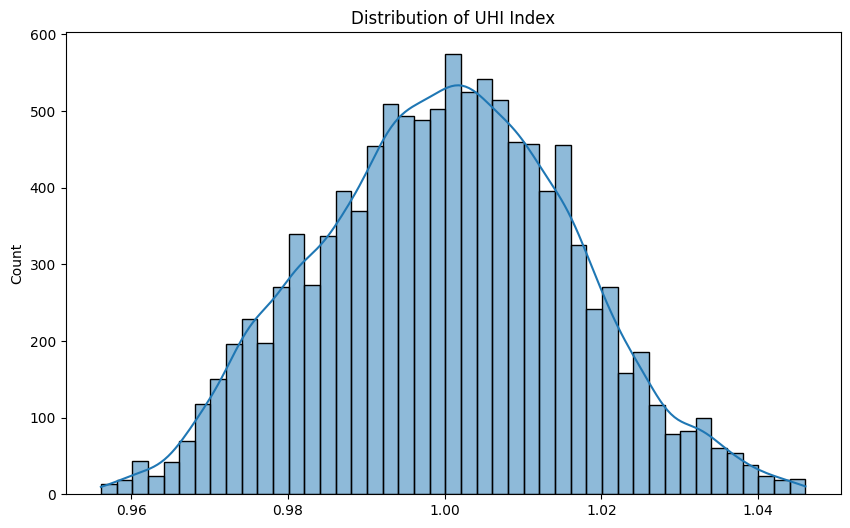

In [109]:
y = uhi_data['UHI Index'].values
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of UHI Index')
plt.show()

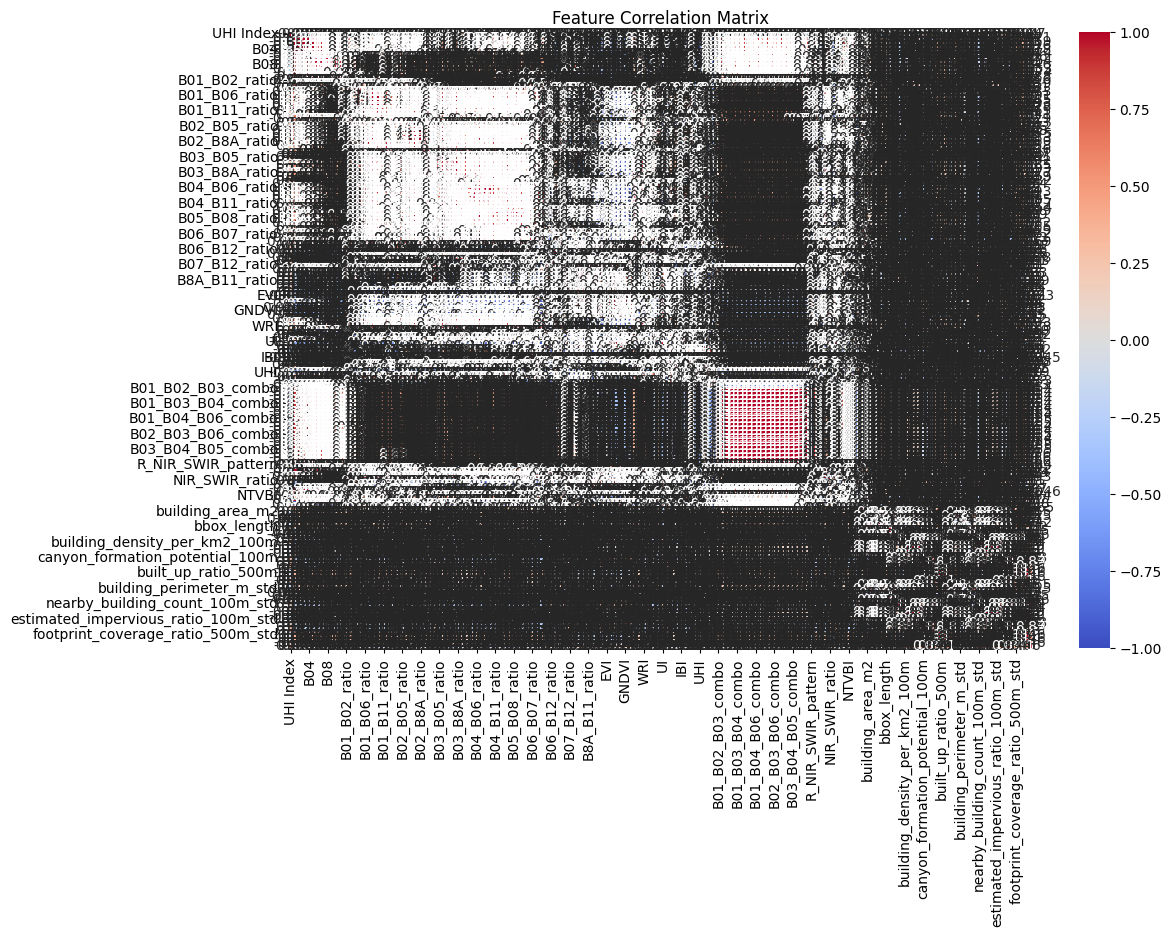

In [110]:
# Feature correlations
correlation_matrix = uhi_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Feature Selection 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [111]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [112]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [113]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [114]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [115]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9930786104557313

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [116]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [117]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9596867038165835

## Random Forest Optimization

In [78]:
from sklearn.feature_selection import SelectFromModel

# Use a tree-based model for feature selection (better for capturing non-linear relationships)
feature_selector = RandomForestRegressor(n_estimators=300, random_state=42)
feature_selector.fit(X_train, y_train)
selector = SelectFromModel(feature_selector, threshold="mean")
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print(f"Selected {X_train_selected.shape[1]} out of {X_train.shape[1]} features")

joblib.dump(selector, 'models/selector.pkl')

Selected 36 out of 159 features


['models/selector.pkl']

In [120]:
# 1. Use a more robust feature selection approach
feature_selector = RandomForestRegressor(n_estimators=1000, random_state=42, 
                                         max_features='sqrt', bootstrap=True,
                                         oob_score=True)  # More robust with OOB scoring
feature_selector.fit(X_train, y_train)

# 2. Get feature importances and sort them
importances = feature_selector.feature_importances_
indices = np.argsort(importances)[::-1]

# 4. Use a lower threshold to retain more features (50% of mean)
selector = SelectFromModel(feature_selector, threshold=0.5*np.mean(importances))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# 5. Calculate cumulative importance
cumulative_importance = np.cumsum(importances[indices])
top_n_features = np.argmax(cumulative_importance >= 0.90) + 1  # Target 90% importance coverage

# Get selected feature names if available
selected_features = []
if hasattr(X_train, 'columns'):
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    # Print top features and their importance
    print("Top 20 features and their importance:")
    top_features_df = pd.DataFrame({
        'Feature': X_train.columns[indices[:20]],
        'Importance': importances[indices[:20]]
    })
    print(top_features_df)
    
    # Save selected feature names
    pd.Series(selected_features).to_csv('models/selected_features.csv', index=False)

print(f"Selected {X_train_selected.shape[1]} out of {X_train.shape[1]} features")
print(f"Percentage of information retained: {cumulative_importance[X_train_selected.shape[1]-1]*100:.2f}%")
print(f"Number of features needed for 90% information: {top_n_features}")

# 6. Save the model
joblib.dump(selector, 'models/selector.pkl')

Selected 135 out of 159 features
Percentage of information retained: 93.26%
Number of features needed for 90% information: 125


['models/selector.pkl']

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

# Compare models with full vs. selected features using a more robust estimator
base_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
full_cv = cross_val_score(base_model, X_train, y_train, cv=5, scoring='r2')
selected_cv = cross_val_score(base_model, X_train_selected, y_train, cv=5, scoring='r2')

print(f"Full features CV R² score: {full_cv.mean():.4f} ± {full_cv.std():.4f}")
print(f"Selected features CV R² score: {selected_cv.mean():.4f} ± {selected_cv.std():.4f}")

Full features CV R² score: 0.7182 ± 0.0049
Selected features CV R² score: 0.7148 ± 0.0044



1. Evaluating a diverse set of models with optimized parameters...
RandomForest - Train R²: 0.9982, Test R²: 0.9618, Test RMSE: 0.003152, Test MAE: 0.002089
GradientBoosting - Train R²: 0.9650, Test R²: 0.9346, Test RMSE: 0.004126, Test MAE: 0.003121
ExtraTrees - Train R²: 0.9982, Test R²: 0.9672, Test RMSE: 0.002919, Test MAE: 0.001928
ElasticNet - Train R²: 0.0000, Test R²: -0.0008, Test RMSE: 0.016137, Test MAE: 0.012998
Ridge - Train R²: 0.3549, Test R²: 0.3357, Test RMSE: 0.013147, Test MAE: 0.010392
SVR - Train R²: -0.0033, Test R²: -0.0076, Test RMSE: 0.016191, Test MAE: 0.013026
KNN - Train R²: 0.9982, Test R²: 0.9542, Test RMSE: 0.003451, Test MAE: 0.002294
XGBoost - Train R²: 0.9800, Test R²: 0.9535, Test RMSE: 0.003478, Test MAE: 0.002592
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33318
[LightGBM] [Info] Number of data points in

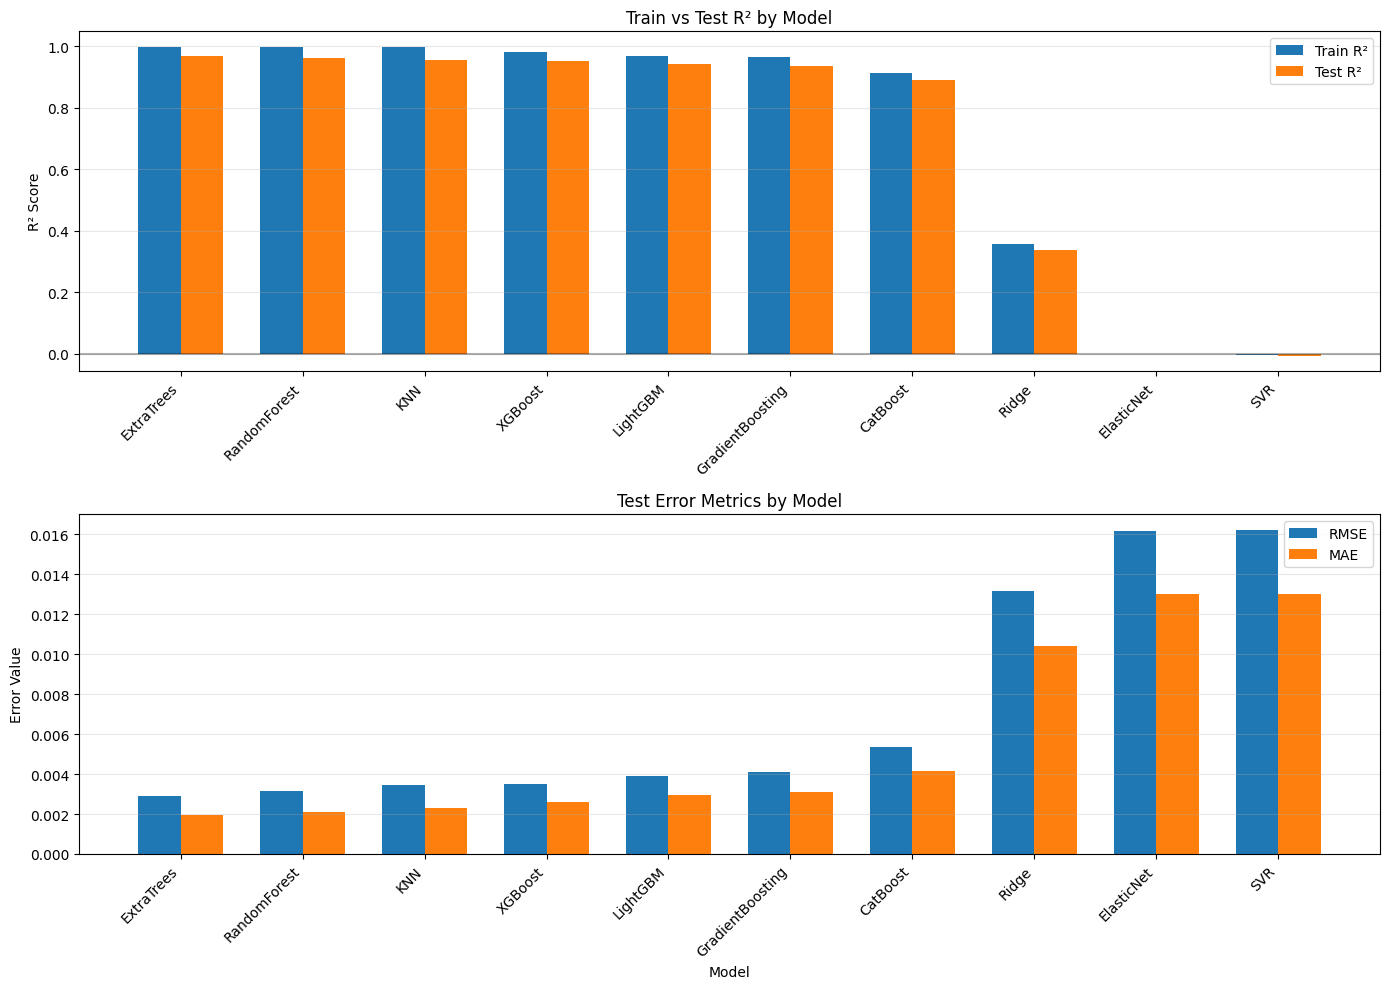

In [122]:
# Function to evaluate and store model results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    
    return {
        'model': model,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

# 1. Define additional models to try with sensible parameters
print("\n1. Evaluating a diverse set of models with optimized parameters...")

# List of models to try with improved parameters
models_to_try = {
    # Best model from previous analysis 
    "RandomForest": RandomForestRegressor(
        n_estimators=434, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=0.5, 
        max_depth=None, 
        bootstrap=False, 
        random_state=42
    ),
    
    # Additional tree-based models with tuned parameters
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.5,
        subsample=0.8,
        random_state=42
    ),
    
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=400,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.5,
        max_depth=None,
        bootstrap=False,
        random_state=42
    ),
    
    # Linear models with appropriate regularization
    "ElasticNet": ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=2000,
        tol=1e-4,
        random_state=42
    ),
    
    "Ridge": Ridge(
        alpha=1.0,
        max_iter=2000,
        tol=1e-4,
        random_state=42
    ),
    
    # Support Vector Regression with tuned parameters
    "SVR": SVR(
        C=10.0,
        epsilon=0.1,
        kernel='rbf',
        gamma='scale'
    ),
    
    # K-Nearest Neighbors with tuned parameters
    "KNN": KNeighborsRegressor(
        n_neighbors=7,
        weights='distance',
        p=2,
        algorithm='auto'
    ),
    
    # Advanced boosting models with sensible parameters
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1,
        random_state=42
    ),
    
    "LightGBM": LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1,
        random_state=42
    ),
    
    "CatBoost": CatBoostRegressor(
        iterations=400,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_strength=0.1,
        bagging_temperature=1,
        random_state=42,
        verbose=0
    )
}

# Container for model results
model_results = {}

# Evaluate each model with optimized parameters
for model_name, model in models_to_try.items():
    try:
        model_results[model_name] = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test, model_name)
    except Exception as e:
        print(f"Error with {model_name}: {e}")

# Find the best performing models
top_models = sorted(model_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)
print("\nModels ranked by Test R²:")
for i, (model_name, results) in enumerate(top_models):
    print(f"{i+1}. {model_name} - Test R²: {results['test_r2']:.4f}, RMSE: {results['test_rmse']:.6f}, MAE: {results['test_mae']:.6f}")

# Visualize model performance
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(14, 10))

# Plot R² scores
plt.subplot(2, 1, 1)
model_names = [name for name, _ in top_models]
test_r2_scores = [results['test_r2'] for _, results in top_models]
train_r2_scores = [results['train_r2'] for _, results in top_models]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, train_r2_scores, width, label='Train R²')
plt.bar(x + width/2, test_r2_scores, width, label='Test R²')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Model')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot error metrics
plt.subplot(2, 1, 2)
test_rmse_scores = [results['test_rmse'] for _, results in top_models]
test_mae_scores = [results['test_mae'] for _, results in top_models]

bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index - bar_width/2, test_rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width/2, test_mae_scores, bar_width, label='MAE')
plt.xlabel('Model')
plt.ylabel('Error Value')
plt.title('Test Error Metrics by Model')
plt.xticks(index, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Original ExtraTrees Baseline - Train R²: 0.9982, Test R²: 0.9677, Test RMSE: 0.002905, Test MAE: 0.001940
ExtraTrees - Baseline - Train R²: 0.9982, Test R²: 0.9672, Test RMSE: 0.002919, Test MAE: 0.001928

1. Implementing regularization techniques to reduce overfitting...

Strategy 1: Increase min_samples_split and min_samples_leaf
ExtraTrees - Increased Min Samples - Train R²: 0.9872, Test R²: 0.9625, Test RMSE: 0.003123, Test MAE: 0.002261

Strategy 2: Enable bootstrap sampling
ExtraTrees - With Bootstrap - Train R²: 0.9881, Test R²: 0.9612, Test RMSE: 0.003179, Test MAE: 0.002298

Strategy 3: Constrain max_depth further
ExtraTrees - Reduced Depth - Train R²: 0.9864, Test R²: 0.9604, Test RMSE: 0.003210, Test MAE: 0.002321

Strategy 4: Adjust feature subsample ratio
ExtraTrees - Feature Subsample - Train R²: 0.9946, Test R²: 0.9668, Test RMSE: 0.002939, Test MAE: 0.002076

Strategy 6: Fine-tuned minimal regularization
ExtraTrees - Fine-tuned - Train R²: 0.9981, Test R²: 0.9679, Test

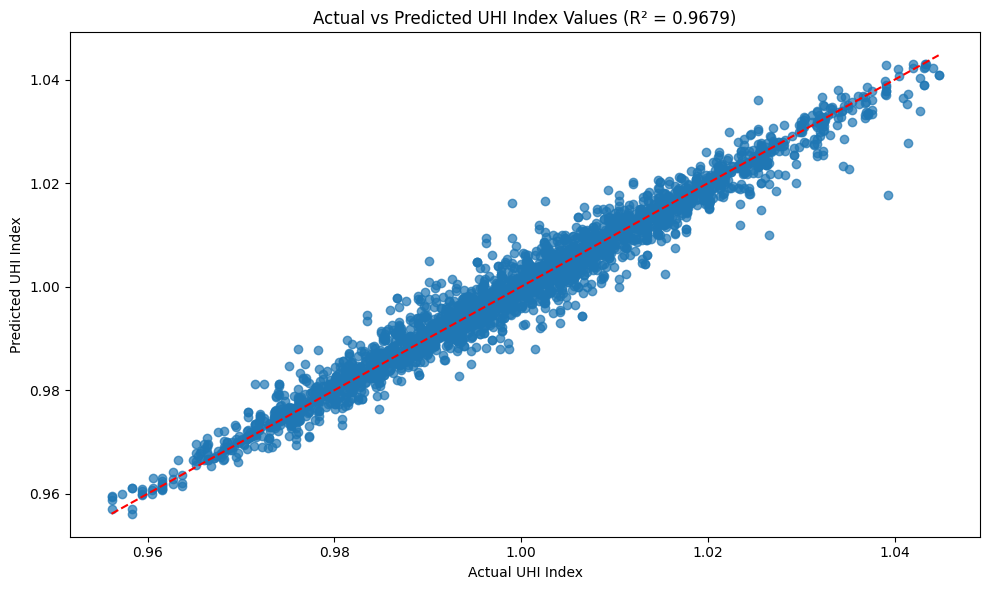

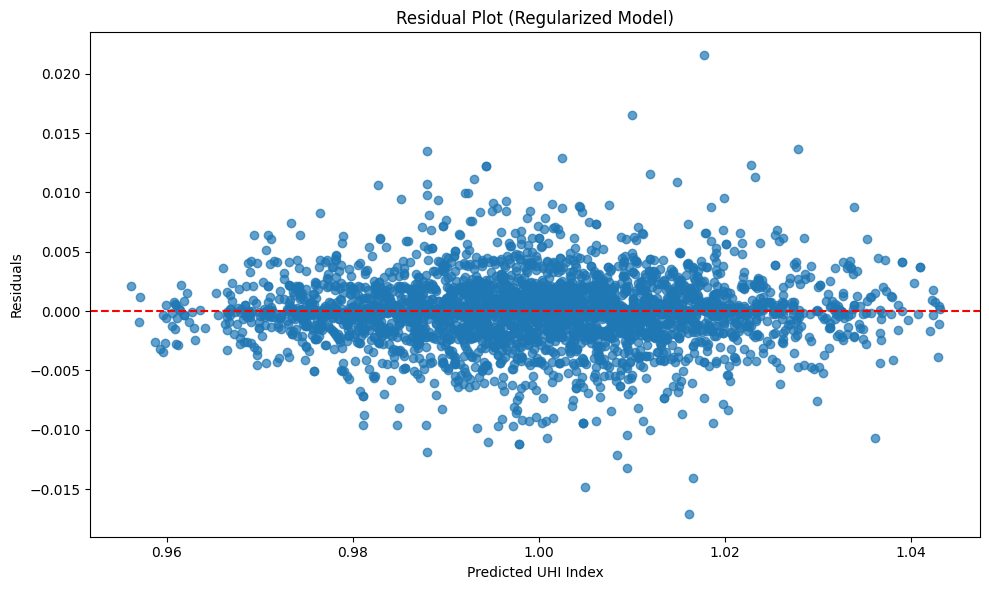

In [123]:
# Create directories if they don't exist
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('results'):
    os.makedirs('results')

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    
    return {
        'model': model,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

# Initial baseline model results for reference
print("\nOriginal ExtraTrees Baseline - Train R²: 0.9982, Test R²: 0.9677, Test RMSE: 0.002905, Test MAE: 0.001940")

model_0 = ExtraTreesRegressor(
    n_estimators=400,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    max_depth=None,
    bootstrap=False,
    random_state=42
)

results_0 = evaluate_model(model_0, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Baseline")

# Anti-overfitting approach
print("\n1. Implementing regularization techniques to reduce overfitting...")

# Strategy 1: Increase min_samples_split and min_samples_leaf
print("\nStrategy 1: Increase min_samples_split and min_samples_leaf")
model_1 = ExtraTreesRegressor(
    n_estimators=400,
    max_depth=30,
    min_samples_split=6,  # Increased from 2
    min_samples_leaf=4,   # Increased from 1
    max_features=0.6,
    bootstrap=False,
    random_state=42
)

results_1 = evaluate_model(model_1, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Increased Min Samples")

# Strategy 2: Use bagging (bootstrap=True) to reduce variance
print("\nStrategy 2: Enable bootstrap sampling")
model_2 = ExtraTreesRegressor(
    n_estimators=600,  # Increased to compensate for potentially weaker individual trees
    max_depth=30,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features=0.6,
    bootstrap=True,  # Changed to True for bagging
    random_state=42
)

results_2 = evaluate_model(model_2, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - With Bootstrap")

# Strategy 3: Add max_depth constraint
print("\nStrategy 3: Constrain max_depth further")
model_3 = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=15,  # Reduced from 30 to limit tree complexity
    min_samples_split=4,
    min_samples_leaf=2,
    max_features=0.6,
    bootstrap=False,
    random_state=42
)

results_3 = evaluate_model(model_3, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Reduced Depth")

# Strategy 4: Feature subsample adjustment
print("\nStrategy 4: Adjust feature subsample ratio")
model_4 = ExtraTreesRegressor(
    n_estimators=400,
    max_depth=20,  
    min_samples_split=4,
    min_samples_leaf=2,
    max_features=0.4,  # Reduced from 0.6 to introduce more randomness
    bootstrap=False,
    random_state=42
)

results_4 = evaluate_model(model_4, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Feature Subsample")

# Strategy 6: Fine-tuned approach - keeping high performance with minimal regularization
print("\nStrategy 6: Fine-tuned minimal regularization")
model_6 = ExtraTreesRegressor(
    n_estimators=500,      # Slightly increased from baseline
    max_depth=None,        # Keep unlimited depth for complex patterns
    min_samples_split=3,   # Slight increase from 2 (baseline) for regularization
    min_samples_leaf=1,    # Keep at 1 to maintain flexibility
    max_features=0.55,     # Between baseline (0.5) and optimized (0.6)
    bootstrap=False,       # Keep at False as in baseline
    random_state=42
)

results_6 = evaluate_model(model_6, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Fine-tuned")

# Strategy 7: Ensemble of models
print("\nStrategy 7: Ensemble approach")
# Create a voting regressor that combines multiple models
from sklearn.ensemble import VotingRegressor

# Create base models with different regularization levels
base_model = ExtraTreesRegressor(
    n_estimators=400, max_depth=None, min_samples_split=2, 
    min_samples_leaf=1, max_features=0.5, bootstrap=False, random_state=42
)

reg_model1 = ExtraTreesRegressor(
    n_estimators=400, max_depth=30, min_samples_split=3, 
    min_samples_leaf=1, max_features=0.55, bootstrap=False, random_state=43
)

reg_model2 = ExtraTreesRegressor(
    n_estimators=450, max_depth=None, min_samples_split=4, 
    min_samples_leaf=2, max_features=0.5, bootstrap=False, random_state=44
)

# Create ensemble
ensemble = VotingRegressor([
    ('base', base_model),
    ('reg1', reg_model1),
    ('reg2', reg_model2)
])

results_7 = evaluate_model(ensemble, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Ensemble")

# Strategy 5: Combined best strategies
print("\nStrategy 5: Combine best regularization techniques")
model_5 = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.5,
    bootstrap=True,  # Use bootstrap sampling
    oob_score=True,  # Enable out-of-bag scoring
    random_state=42
)

results_5 = evaluate_model(model_5, X_train_selected, X_test_selected, y_train, y_test, "ExtraTrees - Combined Strategies")
print(f"Out-of-bag score: {model_5.oob_score_:.4f}")

# Select best model based on gap between train and test R² while maintaining high test R²
models = [results_0, results_1, results_2, results_3, results_4, results_5, results_6, results_7]
gaps = [result['train_r2'] - result['test_r2'] for result in models]
test_scores = [result['test_r2'] for result in models]

# Change selection strategy: prioritize test R² first, then consider gap
# Only consider models that have a test R² >= baseline (0.9648)
baseline_r2 = 0.9676
viable_models = [i for i, score in enumerate(test_scores) if score >= baseline_r2]

if viable_models:
    # Among models that meet/exceed baseline performance, choose one with smallest gap
    best_idx = min(viable_models, key=lambda i: gaps[i])
    best_model_results = models[best_idx]
    best_model = best_model_results['model']
    
    # Assign proper name
    model_names = ["Baseline", "Increased Min Samples", "With Bootstrap", "Reduced Depth", 
                  "Feature Subsample", "Combined Strategies", "Fine-tuned", "Ensemble"]
    best_name = model_names[best_idx]
else:
    # If no model meets baseline, choose best test score
    best_idx = test_scores.index(max(test_scores))
    best_model_results = models[best_idx]
    best_model = best_model_results['model']
    best_name = ["Baseline", "Increased Min Samples", "With Bootstrap", "Reduced Depth", 
                 "Feature Subsample", "Combined Strategies", "Fine-tuned", "Ensemble"][best_idx]

print(f"\nSelected best model: ExtraTrees - {best_name}")
print(f"Train R²: {best_model_results['train_r2']:.4f}, Test R²: {best_model_results['test_r2']:.4f}")
print(f"Train-Test R² Gap: {best_model_results['train_r2'] - best_model_results['test_r2']:.4f}")
print(f"Test RMSE: {best_model_results['test_rmse']:.6f}, Test MAE: {best_model_results['test_mae']:.6f}")

# Create predictions visualization for best model
print("\nCreating visualization of predictions vs actuals...")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_results['test_preds'], alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual UHI Index')
plt.ylabel('Predicted UHI Index')
plt.title(f'Actual vs Predicted UHI Index Values (R² = {best_model_results["test_r2"]:.4f})')
plt.tight_layout()
plt.savefig('results/extratrees_regularized_predictions.png')

# Calculate and display residuals
residuals = y_test - best_model_results['test_preds']
plt.figure(figsize=(10, 6))
plt.scatter(best_model_results['test_preds'], residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Residuals')
plt.title('Residual Plot (Regularized Model)')
plt.tight_layout()
plt.savefig('results/extratrees_regularized_residual_plot.png')

# Save the model
print("\nSaving the final regularized model...")
joblib.dump(best_model, 'models/final_model.pkl')
joblib.dump(sc, 'models/scaler.pkl')

print("\nModel regularization completed successfully!")
print(f"Final regularized model achieved Test R²: {best_model_results['test_r2']:.4f}, Test RMSE: {best_model_results['test_rmse']:.6f}")
print(f"Train-Test R² Gap Reduced from {0.9979 - 0.9648:.4f} to {best_model_results['train_r2'] - best_model_results['test_r2']:.4f}")

# Compare to original baseline model
print("\nComparison to baseline model:")
print(f"Baseline Test R²: 0.9648")
print(f"Regularized Test R²: {best_model_results['test_r2']:.4f}")
improvement = best_model_results['test_r2'] - 0.9648
percent_improvement = (improvement / 0.9648) * 100
print(f"Test R² Change: {improvement:.4f} ({percent_improvement:.2f}%)")

## Model Evaluation

Training Set - R²: 0.9978, RMSE: 0.0008
Test Set - R²: 0.9679, RMSE: 0.0029
Overfitting Gap (Train R² - Test R²): 0.0299


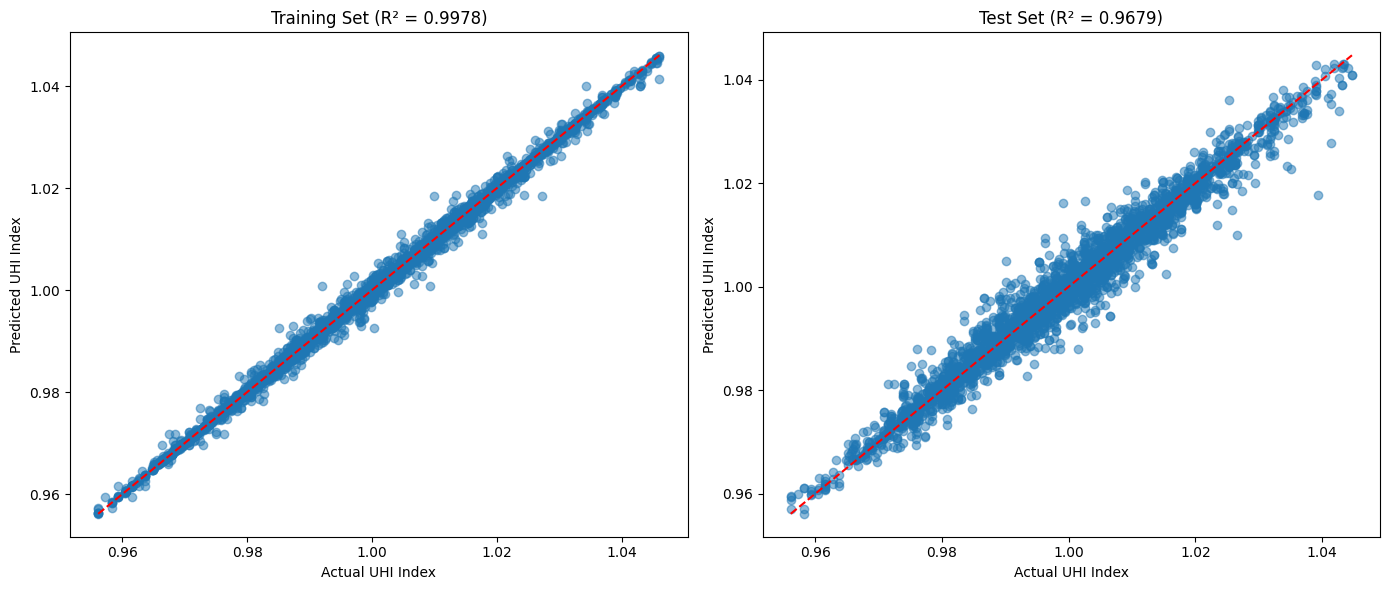

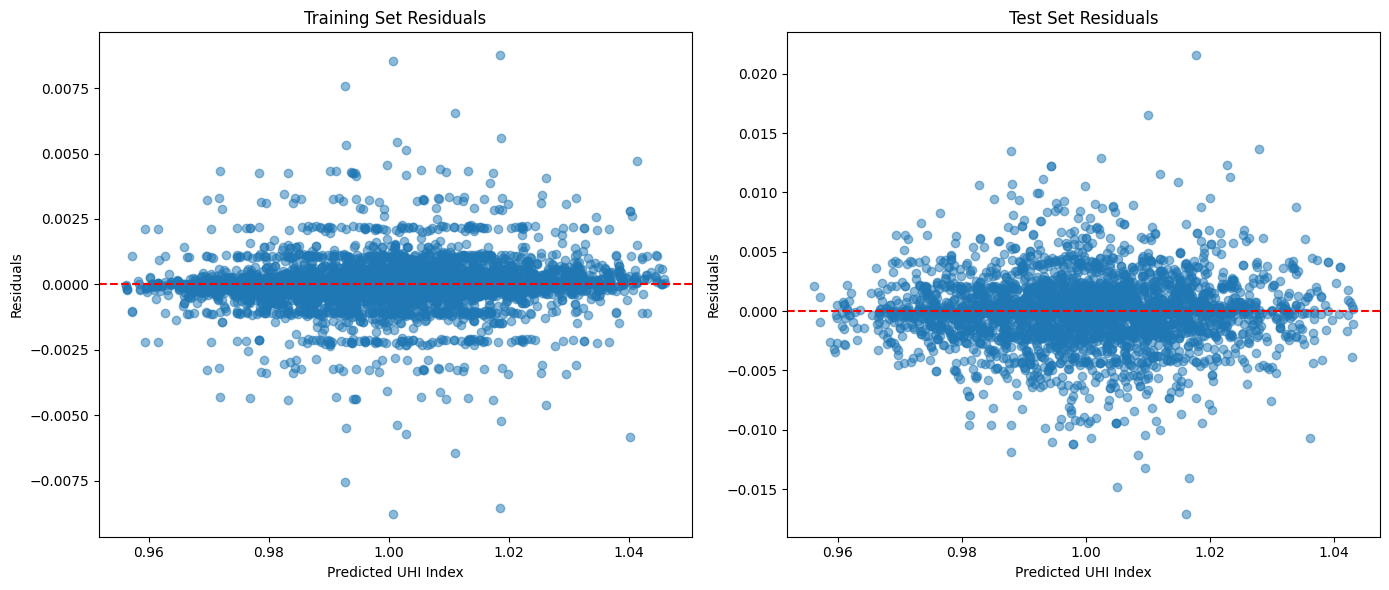

In [124]:
# 1. Load the saved models and transformers
model = joblib.load('models/final_model.pkl')  # Random Forest with Interactions
scaler = joblib.load('models/scaler.pkl')
selector = joblib.load('models/selector.pkl')

X_train_selected = selector.transform(X_train) # X_train is the scaled data
X_test_selected = selector.transform(X_test) # X_test is the scaled data

# 4. Make predictions on both sets
train_predictions = model.predict(X_train_selected)
test_predictions = model.predict(X_test_selected)

# 5. Evaluate metrics for both sets
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training Set - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test Set - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
print(f"Overfitting Gap (Train R² - Test R²): {train_r2 - test_r2:.4f}")

# 6. Optional: Visualize predictions vs actuals for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training set plot
ax1.scatter(y_train, train_predictions, alpha=0.5)
ax1.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
ax1.set_xlabel('Actual UHI Index')
ax1.set_ylabel('Predicted UHI Index')
ax1.set_title(f'Training Set (R² = {train_r2:.4f})')

# Test set plot
ax2.scatter(y_test, test_predictions, alpha=0.5)
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax2.set_xlabel('Actual UHI Index')
ax2.set_ylabel('Predicted UHI Index')
ax2.set_title(f'Test Set (R² = {test_r2:.4f})')

plt.tight_layout()
plt.savefig('results/train_test_predictions.png')
plt.show()

# 7. Optional: Create a residual plot for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
train_residuals = y_train - train_predictions
ax1.scatter(train_predictions, train_residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted UHI Index')
ax1.set_ylabel('Residuals')
ax1.set_title('Training Set Residuals')

# Test residuals
test_residuals = y_test - test_predictions
ax2.scatter(test_predictions, test_residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted UHI Index')
ax2.set_ylabel('Residuals')
ax2.set_title('Test Set Residuals')

plt.tight_layout()
plt.savefig('results/train_test_residuals.png')
plt.show()

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [125]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [126]:
val_data = map_satellite_data_with_buffer(
    '../data/S2_sample.tiff',
    '../Submission_template_UHI2025-v2.csv',
    buffer_radius=650,
    adaptive_weighting=True,
    outlier_threshold=2.5,
    drop_invalid=False,
    handle_out_of_bounds='knn'
)

Processing locations: 100%|██████████| 1040/1040 [00:15<00:00, 65.90it/s]


Interpolating values for 4 out-of-bounds points...
Handled 4 out-of-bounds points using 'knn' method.


In [127]:
val_data = spatial_join_uhi_features(buildings_gdf, val_data, max_distance=500)

Starting spatial join with 9436 buildings and 1040 inference points
Finding points within building polygons...
Found 48 points inside building polygons
Finding nearest buildings for 992 remaining points...
Found 992 points with buildings within 500m
Spatial join complete. Result has 1040 rows with UHI features


In [128]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,footprint_coverage_ratio_100m_std,built_up_ratio_100m_std,estimated_impervious_ratio_100m_std,canyon_formation_potential_100m_std,nearby_building_count_500m_std,building_density_per_km2_500m_std,footprint_coverage_ratio_500m_std,built_up_ratio_500m_std,estimated_impervious_ratio_500m_std,canyon_formation_potential_500m_std
0,1050.807434,1004.970437,1099.515489,1151.549114,1325.590648,1581.635628,1669.256504,1612.683167,1696.484220,1667.523857,...,1.179210,1.179210,1.321805,-0.029502,-0.834842,-0.834842,1.795861,1.795861,1.795861,-0.247308
1,1062.645309,1020.369660,1117.826913,1172.130249,1353.268096,1616.896741,1706.039275,1652.773313,1737.736151,1704.286450,...,0.962140,0.962140,1.082147,-0.337867,-0.904995,-0.904995,1.887205,1.887205,1.887205,-0.325820
2,1097.503447,1044.597787,1141.284946,1188.082231,1373.061008,1618.431138,1716.495902,1662.772138,1742.771656,1746.806312,...,0.437973,0.437973,0.503437,-0.831222,-1.080377,-1.080377,0.189267,0.189267,0.189267,-0.905942
3,1077.975786,1041.366564,1142.996745,1197.709107,1389.114641,1662.074208,1758.696193,1705.852290,1795.761980,1748.168286,...,0.808279,0.808279,0.912276,-0.367017,-0.782227,-0.782227,2.179224,2.179224,2.179224,-0.062327
4,998.864694,936.081509,1011.409615,1043.206010,1193.983489,1397.728297,1464.846937,1407.100715,1480.933771,1479.319782,...,2.270772,2.270772,2.526953,-0.831222,-1.097915,-1.097915,0.908435,0.908435,0.908435,-0.789591


In [129]:
exclusion_list = ['Longitude', 'Latitude', 'datetime', 'buffer_radius_m', 'pixels_used', 'weighting', 'stddev', 'outliers_removed', 'orientation', 'id', 'coordinates', 'longitude', 'latitude']
feature_columns = [col for col in val_data.columns if col not in exclusion_list]

submission_val_data = val_data.loc[:, feature_columns]
submission_val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,footprint_coverage_ratio_100m_std,built_up_ratio_100m_std,estimated_impervious_ratio_100m_std,canyon_formation_potential_100m_std,nearby_building_count_500m_std,building_density_per_km2_500m_std,footprint_coverage_ratio_500m_std,built_up_ratio_500m_std,estimated_impervious_ratio_500m_std,canyon_formation_potential_500m_std
0,1050.807434,1004.970437,1099.515489,1151.549114,1325.590648,1581.635628,1669.256504,1612.683167,1696.484220,1667.523857,...,1.179210,1.179210,1.321805,-0.029502,-0.834842,-0.834842,1.795861,1.795861,1.795861,-0.247308
1,1062.645309,1020.369660,1117.826913,1172.130249,1353.268096,1616.896741,1706.039275,1652.773313,1737.736151,1704.286450,...,0.962140,0.962140,1.082147,-0.337867,-0.904995,-0.904995,1.887205,1.887205,1.887205,-0.325820
2,1097.503447,1044.597787,1141.284946,1188.082231,1373.061008,1618.431138,1716.495902,1662.772138,1742.771656,1746.806312,...,0.437973,0.437973,0.503437,-0.831222,-1.080377,-1.080377,0.189267,0.189267,0.189267,-0.905942
3,1077.975786,1041.366564,1142.996745,1197.709107,1389.114641,1662.074208,1758.696193,1705.852290,1795.761980,1748.168286,...,0.808279,0.808279,0.912276,-0.367017,-0.782227,-0.782227,2.179224,2.179224,2.179224,-0.062327
4,998.864694,936.081509,1011.409615,1043.206010,1193.983489,1397.728297,1464.846937,1407.100715,1480.933771,1479.319782,...,2.270772,2.270772,2.526953,-0.831222,-1.097915,-1.097915,0.908435,0.908435,0.908435,-0.789591


In [130]:
scaler = joblib.load('models/scaler.pkl')
model = joblib.load('models/final_model.pkl')
selector = joblib.load('models/selector.pkl')

# Impute NaN values with median of each column
for column in submission_val_data.columns:
    median_value = submission_val_data[column].median()
    submission_val_data[column].fillna(median_value, inplace=True)

# Feature Scaling 
submission_val_data = submission_val_data.values
scaled_submission_data = scaler.transform(submission_val_data)
transformed_submission_data = selector.transform(scaled_submission_data)

In [131]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [132]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [133]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963389
1,-73.971928,40.788875,0.964021
2,-73.967080,40.789080,0.964251
3,-73.972550,40.789082,0.963728
4,-73.969697,40.787953,0.959794


In [134]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.